In [1]:
import deepcell

In [2]:
base_url = ('https://deepcell-data.s3-us-west-1.amazonaws.com/'
            'demos/janelia/hela_s3_{}_256.npz')

nuclear = deepcell.datasets.Dataset(
    path='nuclear.npz',
    url=base_url.format('nuclear'),
    file_hash='04a200f437aa2f7c66d636c84c379ba7',
    metadata=None
)

fluo_cyto = deepcell.datasets.Dataset(
    path='fluo_cyto.npz',
    url=base_url.format('fluo_cyto'),
    file_hash='6a8a3ba4ddf3de8bb90776fa41a5a664',
    metadata=None
)

phase = deepcell.datasets.Dataset(
    path='phase.npz',
    url=base_url.format('phase'),
    file_hash='c56df51039fe6cae15c818118dfb8ce8',
    metadata=None
)

In [3]:
dataset = fluo_cyto  # Change this to another dataset! (nuclear, phase, fluo_cyto)

test_size = 0.2 # fraction of data saved as test
seed = 0 # seed for random train-test split

(X_train, y_train), (X_test, y_test) = dataset.load_data(
    test_size=test_size, seed=seed)

print('X_train.shape: {}\nX_test.shape: {}'.format(
    X_train.shape, X_test.shape))

X_train.shape: (1872, 256, 256, 1)
X_test.shape: (468, 256, 256, 1)


In [4]:
from deepcell.model_zoo.panopticnet import PanopticNet

semantic_classes = [1, 1, 2] # inner distance, outer distance, fgbg

model = PanopticNet(
    backbone='resnet50',
    input_shape=X_train.shape[1:],
    norm_method='whole_image',
    num_semantic_classes=semantic_classes)

2022-10-10 15:28:06.300339: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-10-10 15:28:08.200890: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10429 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:5e:00.0, compute capability: 6.1


In [5]:
from tensorflow.keras.optimizers import SGD, Adam
from deepcell.utils.train_utils import rate_scheduler

n_epoch = 5

lr = 1e-4
optimizer = Adam(lr=lr, clipnorm=0.001)
lr_sched = rate_scheduler(lr=lr, decay=0.99)

batch_size = 8

min_objects = 2

/app/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [6]:
from deepcell import image_generators

transforms = ['inner-distance', 'outer-distance', 'fgbg']
transforms_kwargs = {'outer-distance': {'erosion_width': 0}}


# use augmentation for training but not validation
datagen = image_generators.SemanticDataGenerator(
    rotation_range=180,
    fill_mode='reflect',
    zoom_range=(0.75, 1.25),
    horizontal_flip=True,
    vertical_flip=True)

datagen_val = image_generators.SemanticDataGenerator()
    
train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)

val_data = datagen_val.flow(
    {'X': X_test, 'y': y_test},
    seed=seed,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)

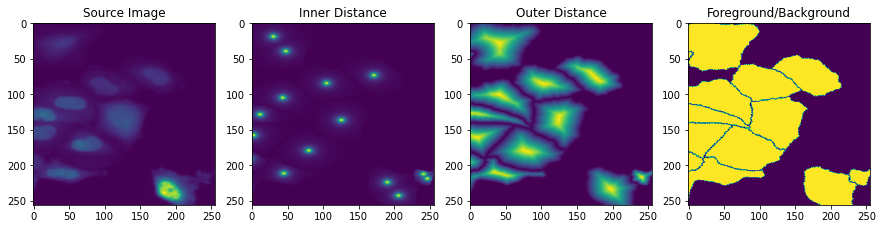

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline

inputs, outputs = train_data.next()

img = inputs[0]
inner_distance = outputs[0]
outer_distance = outputs[1]
fgbg = outputs[2]

fig, axes = plt.subplots(1, 4, figsize=(15, 15))

axes[0].imshow(img[..., 0])
axes[0].set_title('Source Image')

axes[1].imshow(inner_distance[0, ..., 0])
axes[1].set_title('Inner Distance')

axes[2].imshow(outer_distance[0, ..., 0])
axes[2].set_title('Outer Distance')

axes[3].imshow(fgbg[0, ..., 1])
axes[3].set_title('Foreground/Background')

plt.show()

In [9]:
# Create a dictionary of losses for each semantic head
from tensorflow.keras.losses import MSE
from deepcell.losses import weighted_categorical_crossentropy


def semantic_loss(n_classes):
    def _semantic_loss(y_pred, y_true):
        if n_classes > 1:
            return 0.01 * weighted_categorical_crossentropy(
                y_pred, y_true, n_classes=n_classes)
        return MSE(y_pred, y_true)
    return _semantic_loss


loss = {}

# Give losses for all of the semantic heads
for layer in model.layers:
    if layer.name.startswith('semantic_'):
        n_classes = layer.output_shape[-1]
        loss[layer.name] = semantic_loss(n_classes)

In [11]:
model.compile(loss=loss, optimizer=optimizer)

In [12]:
# fit the model
from deepcell.utils.train_utils import get_callbacks
from deepcell.utils.train_utils import count_gpus

model_name = 'phase_deep_watershed'
model_path = '{}.h5'.format(model_name)

print('Training on', count_gpus(), 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
    monitor='val_loss',
    verbose=1)

loss_history = model.fit(
    train_data,
    steps_per_epoch=train_data.y.shape[0] // batch_size,
    epochs=n_epoch,
    validation_data=val_data,
    validation_steps=val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

Training on 1 GPUs.


2022-10-10 15:32:55.088615: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 10429 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:5e:00.0, compute capability: 6.1


Epoch 1/5


2022-10-10 15:33:12.007897: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8202


234/234 [==============================] - ETA: 0s - loss: 0.0315 - semantic_0_loss: 0.0072 - semantic_1_loss: 0.0225 - semantic_2_loss: 0.0018
Epoch 00001: val_loss improved from inf to 0.04429, saving model to phase_deep_watershed.h5


/app/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


234/234 [==============================] - 95s 283ms/step - loss: 0.0315 - semantic_0_loss: 0.0072 - semantic_1_loss: 0.0225 - semantic_2_loss: 0.0018 - val_loss: 0.0443 - val_semantic_0_loss: 0.0038 - val_semantic_1_loss: 0.0359 - val_semantic_2_loss: 0.0046 - lr: 1.0000e-04
Epoch 2/5
234/234 [==============================] - ETA: 0s - loss: 0.0090 - semantic_0_loss: 0.0022 - semantic_1_loss: 0.0060 - semantic_2_loss: 8.1171e-04
Epoch 00002: val_loss improved from 0.04429 to 0.02205, saving model to phase_deep_watershed.h5
234/234 [==============================] - 65s 278ms/step - loss: 0.0090 - semantic_0_loss: 0.0022 - semantic_1_loss: 0.0060 - semantic_2_loss: 8.1171e-04 - val_loss: 0.0221 - val_semantic_0_loss: 0.0028 - val_semantic_1_loss: 0.0161 - val_semantic_2_loss: 0.0031 - lr: 9.9000e-05
Epoch 3/5
234/234 [==============================] - ETA: 0s - loss: 0.0076 - semantic_0_loss: 0.0019 - semantic_1_loss: 0.0050 - semantic_2_loss: 7.1004e-04
Epoch 00003: val_loss improved

In [13]:
[(layer.name, layer.output_shape) for layer in filter(lambda x: x.name.startswith('semantic_'), model.layers)]

[('semantic_0', (None, 256, 256, 1)),
 ('semantic_1', (None, 256, 256, 1)),
 ('semantic_2', (None, 256, 256, 2))]

In [14]:
from deepcell.model_zoo.panopticnet import PanopticNet

prediction_model = PanopticNet(
    backbone='resnet50',
    norm_method='whole_image',
    num_semantic_classes=[1, 1], # inner distance, outer distance
    input_shape=X_train.shape[1:]
)

In [ ]:
prediction_model.load_weights(model_path, by_name=True)

In [ ]:
# make predictions on testing data
from timeit import default_timer

start = default_timer()
test_images = prediction_model.predict(X_test)
watershed_time = default_timer() - start

print('Watershed segmentation of shape', test_images[0].shape,
      'in', watershed_time, 'seconds.')

In [ ]:
import random

from matplotlib import pyplot as plt

from deepcell_toolbox.deep_watershed import deep_watershed

index = random.randint(0, X_test.shape[0])
print(index)

fig, axes = plt.subplots(1, 4, figsize=(20, 20))

masks = deep_watershed(
    test_images,
    min_distance=10,
    detection_threshold=0.1,
    distance_threshold=0.01,
    exclude_border=False,
    small_objects_threshold=0)

# calculated in the postprocessing above, but useful for visualizing
inner_distance = test_images[0]
outer_distance = test_images[1]

# raw image with centroid
axes[0].imshow(X_test[index, ..., 0])
axes[0].set_title('Raw')

axes[1].imshow(inner_distance[index, ..., 0], cmap='jet')
axes[1].set_title('Inner Distance')
axes[2].imshow(outer_distance[index, ..., 0], cmap='jet')
axes[2].set_title('Outer Distance')
axes[3].imshow(masks[index, ...], cmap='jet')
axes[3].set_title('Instance Mask')

plt.show()